# ETUDE DU VIN

## Intro
Nous avons choisit de récupérer une base de données sur les vins du monde. Cette base contient de nombreuses informations telles que le nom du vin, la région d'où il vient, son prix, sa qualité, etc...
Un des objectifs du projet est de savoir si les meilleurs vins sont les plus chèrs. En effet, on peut se demander si le prix est bien fonction de sa qualité. Le prix des vins pourrait etre uniquement lié à la renommée de ceux-ci. 
On propose alors de faire une régression entre le prix et la qualité du vin. 

Cellule à lancer pour faire les importations nécessaires : 

In [11]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

### I. Nettoyage des données 
Avant de commencer à analyser notre de base de données, on doit nettoyer son contenu. C'est à dire traiter les valeurs manquantes en les supprimant et retirer les doublons pour garantir une analyse fiable et des models pertients. 

Le code suivant permet de faire ceci : 

In [12]:
csv_file='winemag-data-130k-v2.csv'


def nettoyage_et_export(csv_file, output_file):

    data = pd.read_csv(csv_file)
    print(f"Avant le nettoyage : {len(data)} éléments")

 
    data_clean = data.dropna(subset=['price', 'points'])
    data_clean = data_clean[data_clean['price'] > 0]

    print(f"Après le nettoyage : {len(data_clean)} éléments")

    data_clean.to_csv(output_file, index=False)
    print(f"Nouveau jeu de données sauvegardé sous : {output_file}")
    
    

nettoyage_et_export(csv_file, 'data_cleaned.csv')

data=pd.read_csv('data_cleaned.csv')


Avant le nettoyage : 129971 éléments
Après le nettoyage : 120975 éléments
Nouveau jeu de données sauvegardé sous : data_cleaned.csv


### II. Analyse exploratoire 
Cette partie sert à comprendre comment sont réparties nos données. Elle permet aussi de savoir si le pays est un facteur à prendre en compte pour déterminer la qualité du vin. Certains pays pourraient proposer des vins chèrs à cause de leur renommée. Enfin,  l'analyse exploratoire permet de vérifier qu'il existe bien un lien entre le prix du vin et sa qualité, avant qu'on lance des calculs pour faire une régression. 
- Loi suivit par les notes : 

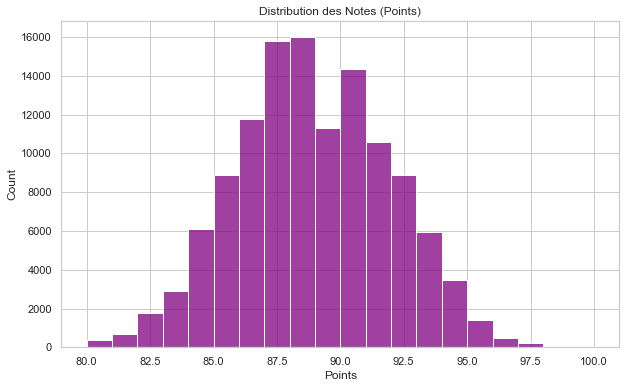

In [13]:

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data['points'], bins=20,  color='purple')
plt.title('Distribution des Notes (Points)')
plt.xlabel('Points')
plt.show()

On observe que les notes sont réparties entre 86 et 96 (faible écart-type). On remarque que la majorité des vins a une note de 91. Notre jeu de données fournit donc uniquement des bons vins. On se demandera par la suite si il existe de grands écarts de prix pour des petites variations de notes.  

On vois un saut de 89 a 90? Bias de ne pas vouloir donner 89 mais 90?


- Quels sont les pays avec les vins les plus chèrs : 

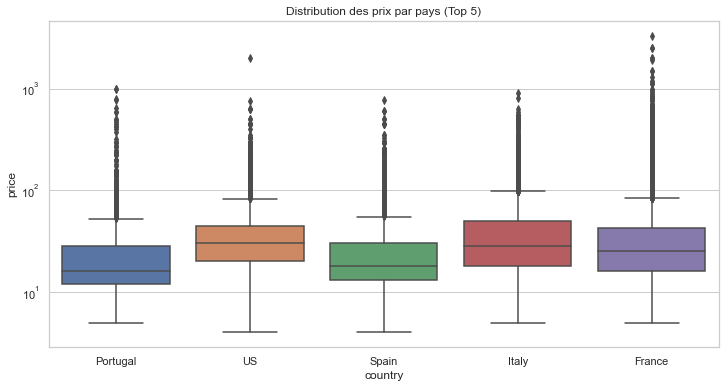

In [14]:

top_countries = data['country'].value_counts().head(5).index
fichier_top_countries = data[data['country'].isin(top_countries)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='country', y='price', data=fichier_top_countries)
plt.yscale('log')

plt.title('Distribution des prix par pays (Top 5)')
plt.show()

D'après le graphique, on remarque qu'on ne peut pas traiter tous les vins de la même manière. Le prix varie selon le pays. Par exemple, les vins espagnols sont en majorité plus chèrs que les vins portuguais. Le prix moyen d'une bouteille est de 75$ en Espagne tandis qu'il est de 25$ au Portugal.
( Nous allons donc nous concentrer sur les gros producteurs et probablement devoir transformer la variable prix (log) pour que notre modèle fonctionne.)

### III. Modélisation 1 : régression prix/qualité 

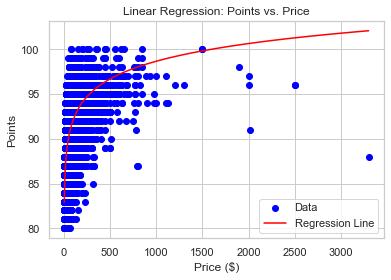

(78.9814187766426, 2.8481142732266598)

In [ ]:
csv_file='data_cleaned.csv'
data=pd.read_csv(csv_file)


def regression_log(x,y):

    log_x = np.log(x)
    
    coefficients = np.polyfit(log_x, y, 1) # returns [b, a]
    
    b = coefficients[0]
    a = coefficients[1]

    
    x_range = np.linspace(x.min(), x.max(), 500)
    y_fit = a + b * np.log(x_range)


    # Plot the data and regression line
    plt.scatter(x, y, color='blue', label='Data')
    plt.plot(x_range, y_fit, color='red', label='Regression Line')
    plt.xlabel('Price ($)')
    plt.ylabel('Points')

    '''
    plt.xlim(left=0)   # set x-axis minimum to 0
    plt.ylim(bottom=0) # set y-axis minimum to 0
    plt.ylim(top=100)  # set y-axis maximum to 100

    '''

    plt.title('Linear Regression: Points vs. Price')
    plt.legend()
    plt.show()

    return a, b

x = data['price'].values
y = data['points'].values
regression_log(x,y)

#### Interprétations : 
On voit d'après le graphique que....

IA a rediger


1. Que représente a (l'ordonnée à l'origine) ?

    Définition mathématique : C'est la valeur de y quand ln(x)=0 (c'est-à-dire quand le prix x=1).

    Interprétation concrète : C'est le "score de base" théorique d'un vin très bon marché (1$).

    Dans vos données : Avec votre résultat précédent (a≈81.05), cela signifie que le modèle estime qu'un vin premier prix commence avec une note de base d'environ 81 points.

2. Que représente b (la pente logarithmique) ?

    Définition mathématique : C'est le taux de variation de la note par rapport au logarithme du prix.

    Interprétation concrète : Il mesure la vitesse à laquelle la note augmente lorsque le prix augmente.

        Si vous multipliez le prix par environ 2,7 (le nombre e), la note augmente de b points.

        Règle simplifiée : Une augmentation du prix de 1% entraîne une augmentation de la note d'environ b/100 points.

    Dans vos données : Avec b≈2.68, une augmentation de 10% du prix se traduit par environ +0.26 point. Pour gagner 2.7 points supplémentaires, il faut multiplier le prix par 2.7.

Conclusions que vous pouvez tirer

    La loi des rendements décroissants : C'est la conclusion la plus importante d'une régression logarithmique. Comme la courbe s'aplatit au fur et à mesure que le prix augmente, cela signifie qu'il devient de plus en plus coûteux d'obtenir des points supplémentaires.

        Passer d'un vin à 10$ à un vin à 20$ aura un impact majeur sur la qualité perçue.

        Passer d'un vin à 100$ à un vin à 110$ (même différence de 10$) n'aura quasiment aucun impact visible sur la note.

    Qualité "plancher" : La valeur de a (81 points) suggère que même les vins les moins chers de votre base de données conservent un certain standard de qualité acceptable (ils ne tombent pas à 0).

    Évaluation du "bon plan" :

        Si un point est au-dessus de la ligne rouge : Le vin est "meilleur que prévu" pour son prix (excellent rapport qualité/prix).

        Si un point est en-dessous de la ligne rouge : Le vin est "trop cher" par rapport à sa qualité théorique.

    Lien de causalité : Le coefficient b positif confirme une corrélation positive : payer plus cher garantit statistiquement une meilleure note, mais avec une efficacité qui diminue rapidement.

#### Choix du vin : 
On peut maintenant choisir quel vin nous testons :

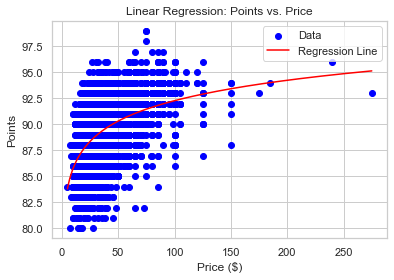

(79.24261556396807, 2.8305528380230545)

In [ ]:

pays='US'
province='Oregon'
def origine(data,country,province=None):

    x= data['price'].values
    y= data['points'].values

    countries = data['country'].values
    provinces = data['province'].values

    indice_1=countries==country
    
    if province is None or province == "":
        indice_2 = np.ones_like(provinces, dtype=bool)
    else:
        indice_2 = (provinces == province)


    valid_indices =  indice_1 & indice_2
    x = x[valid_indices]
    y = y[valid_indices]


    if len(x) < 2:
        print(f"Erreur : Pas assez de données pour {country} {province if province else ''} ({len(x)} points trouvés).")
        return None, None
  

    return regression_log(x, y)

path='data_cleaned.csv'
data = pd.read_csv(path)

origine(data,pays,province)

### Modélisation 2 : Le bon plan ;)

- C'est la partie qui nous interesse... on cherche quel vin a le meilleur rapport qualité/prix.

In [ ]:
prix_max=20

def bon_plan(data, prix_max, points=5):

    x = data['price'].values
    y = data['points'].values

    a,b = regression_log(x, y)

    indices = x <= prix_max
    x = x[indices]
    y = y[indices]

    x_range = np.linspace(x.min(), x.max(), 500)
    y_fit = a + b * np.log(x_range)

    for i in range(len(x)):
        point_estime = a + b * np.log(x[i])
        ecart = y[i] - point_estime
        if ecart > points:
            print(f"Bon plan : Prix = ${x[i]:.2f}, Points = {y[i]} (Écart = {ecart:.2f})")

bon_plan(data, prix_max,7)

NameError: name 'data' is not defined

- On  peut aussi trouver quelle bouteille est la moins chère pour une note donnée.


In [20]:
data=pd.read_csv('data_cleaned.csv')

x = data['price'].values
y = data['points'].values

header = f"{'NOTE':<5} | {'PRIX':>8} | {'DOMAINE (Winery)':<30} | {'VARIÉTÉ':<20} | {'PAYS':<15} | {'ID':<6}"
print(header)
print("-" * len(header))

for i in range(min(y),max(y)+1):


   

    vins= data[data['points'] == i]

    prix_min = vins['price'].min()

    vin_le_moins_cher = vins[vins['price'] == prix_min]

    print(f"{i:<5} | {prix_min:>6.2f} $ | {vin_le_moins_cher['winery'].iloc[0]:<30} | {vin_le_moins_cher['variety'].iloc[0]:<20} | {vin_le_moins_cher['country'].iloc[0]:<15} | {vin_le_moins_cher['id'].iloc[0]} ")

NOTE  |     PRIX | DOMAINE (Winery)               | VARIÉTÉ              | PAYS            | ID    
---------------------------------------------------------------------------------------------------
80    |   5.00 $ | Terrenal                       | Malbec               | Argentina       | 23437 
81    |   5.00 $ | Viña Decana                    | Tempranillo          | Spain           | 33381 
82    |   4.00 $ | Felix Solis                    | White Blend          | Spain           | 117303 
83    |   4.00 $ | Pam's Cuties                   | Chardonnay           | US              | 59507 
84    |   4.00 $ | Broke Ass                      | Malbec-Syrah         | Argentina       | 29553 
85    |   4.00 $ | Felix Solis                    | Syrah                | Spain           | 1987 
86    |   4.00 $ | Bandit                         | Merlot               | US              | 64590 
87    |   5.00 $ | In Situ                        | Sauvignon Blanc      | Chile           | 24592 
